In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [2]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
output_base_folder = Path("/home/ivan/temp/temp-benchmarking/")


# End to End benchmark
---
Storage performance test on S3 and Scratch with changing the size of the batch, number of workers, number of fetchers, and memory pinning.

**Experiment parameters**

| param | range |
| --- | --- |
| batch size | 16, 32, 64 | 
| num fetch workers |  4, 8, 16, 32 | 
| num workers |  0,  4,  8, 16 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |
| pin memory | True, False | 

---

### TOC:
* [S3 Storage](#s3storage)
* [S3 Async vs Threaded Dataloader](#s3asynciovsthreaded)
* [Scratch Storage](#scratchstorage)
* [Scratch Async vs Threaded Dataloader](#scratchasynciovsthreaded)
* [S3 vs Scratch](#s3vsscratch)

**Parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch size | asyncio | --- |
| | threaded | --- |
| num fetch workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initiall placed into the task (worker) queue. |
| | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |
| num workers | asyncio | Number of workers that download batches in paralell (while batch items are usually fetched sequentially, here, they are fetched asynchronously) |
| | threaded | The same as for asyncio implementation, however, batch items are fetched with parallel threads and yealded. Once a batch is collected, it is yealded(1). |
| pin memory (2) | asyncio | Host (CPU) data allocations are pageable by default. The GPU cannot access data directly from pageable host memory, so when a data transfer from pageable host memory to device memory is invoked, the CUDA driver must first allocate a temporary page-locked, or “pinned”, host array, copy the host data to the pinned array, and then transfer the data from the pinned array to device memory. Pinned memory is used as a staging area for transfers from the device to the host. We can avoid the cost of the transfer between pageable and pinned host arrays by directly allocating our host arrays in pinned memory. |
| | threaded | Same as for asyncio |

(1) batch_pool_size - Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentiall or in parallel). This implementation takes N batches, and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded. Fixed to 10, as previous experiments show it doesn't have much influence. 

(2) https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

**In all plots, lower is better!**

Testing script:

```bash
for pin_memory in 0 1; do
  for fetch_impl in "threaded" "asyncio"; do
    for storage in "s3" "scratch"; do
      for batch_size in 16 32 64; do
        for num_workers in 0 4 8 16; do
          for num_fetch_workers in 4 8 16 32; do
            python3 train/imagenet.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/e2e \
            --dataset "${storage}" \
            --num-fetch-workers "${num_fetch_workers}" \
            --num-workers "${num_workers}" \
            --dataset-limit 1024 \
            --batch-size "${batch_size}" \
            --prefetch-factor 2 \
            --fetch-impl "${fetch_impl}" \
            --pin-memory "${pin_memory}" \
            --accelerator dp
          done
        done
      done
    done
  done
done
```

## S3 Storage <a class="anchor" id="s3storage">

In [3]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool"]

In [4]:
df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="latest/e2e/*benchmark_e2e_s3*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15213/15213 [05:35<00:00, 45.34it/s]


In [5]:
df_dataloader_s3_async=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="asyncio"]
df_dataloader_s3_threaded=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="threaded"]
# save memory 
del df_dataloader_s3_full
# show record num
print(f"Records {len(df_dataloader_s3_async)}")
print(f"Records {len(df_dataloader_s3_threaded)}")

Records 1909162
Records 2173076


In [6]:
display(get_run_stats(df_dataloader_s3_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_s3_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                   
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync           1.310854e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync           1.314469e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync           1.322931e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync           1.310854e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync           1.314469e+09   
...                                                                                                              ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync         2.812828e+09   
                                                 20211005f061635_benchmark_e2e_s3_64_16_32_sync         2.887881e+09   
                                                 20211005f131232_benchmark_e2e_s3_16_16_32_sync         2.688887e+09   
                                                 20211005f142730_benchmark_e2e_s3_32_16_32_sync         2.829984e+09   
                                                 20211005f154723_benchmark_e2e_s3_64_16_32_sync         2.887881e+09   

                                                                                                   time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync    1.633394e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync    1.633399e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync    1.633404e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync    1.633428e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync    1.633433e+09   
...                                                                                                       ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync  1.633403e+09   
                                                 20211005f061635_benchmark_e2e_s3_64_16_32_sync  1.633407e+09   
                                                 20211005f131232_benchmark_e2e_s3_16_16_32_sync  1.633432e+09   
                                                 20211005f142730_benchmark_e2e_s3_32_16_32_sync  1.633437e+09   
                                                 20211005f154723_benchmark_e2e_s3_64_16_32_sync  1.633442e+09   

                                                                                                     time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync    1.633395e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync    1.633399e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync    1.633404e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync    1.633429e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync    1.633433e+09   
...                                                                                                       ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync  1.633403e+09   
                                                 

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                   
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync           2.220311e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync           2.491588e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync           2.339791e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync           2.221882e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync           2.493323e+09   
...                                                                                                              ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync         2.599831e+09   
                                                 20211005f014526_benchmark_e2e_s3_64_16_32_sync         2.538207e+09   
                                                 20211005f082157_benchmark_e2e_s3_16_16_32_sync         2.456020e+09   
                                                 20211005f095000_benchmark_e2e_s3_32_16_32_sync         2.640500e+09   
                                                 20211005f111257_benchmark_e2e_s3_64_16_32_sync         2.538207e+09   

                                                                                                   time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync    1.633377e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync    1.633382e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync    1.633387e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync    1.633411e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync    1.633416e+09   
...                                                                                                       ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync  1.633386e+09   
                                                 20211005f014526_benchmark_e2e_s3_64_16_32_sync  1.633391e+09   
                                                 20211005f082157_benchmark_e2e_s3_16_16_32_sync  1.633415e+09   
                                                 20211005f095000_benchmark_e2e_s3_32_16_32_sync  1.633420e+09   
                                                 20211005f111257_benchmark_e2e_s3_64_16_32_sync  1.633425e+09   

                                                                                                     time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync    1.633377e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync    1.633382e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync    1.633388e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync    1.633411e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync    1.633416e+09   
...                                                                                                       ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync  1.633387e+09   
                                                 

### Filter

In [7]:
print(np.unique(df_dataloader_s3_async["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["batch_size"].to_numpy()))

[ 0  4  8 16]
[ 4  8 16 32]
[16 32 64]


In [8]:
import seaborn as sns

def filter_data(df):
    data = pd.DataFrame()
    for num_workers in np.unique(df["num_workers"].to_numpy()):
        for num_fetch_workers in np.unique(df["num_fetch_workers"].to_numpy()):
            for batch_size in np.unique(df["batch_size"].to_numpy()):
                for pin_memory in np.unique(df["pin_memory"].to_numpy()):
                    df_temp=df[(df["num_workers"]==num_workers) &
                                                 (df["num_fetch_workers"]==num_fetch_workers) &
                                                 (df["batch_size"]==batch_size) &
                                                 (df["pin_memory"]==pin_memory)]
                    df_step_time = df_temp[df_temp["trace_name"]=="(6)-training_step"]
                    step_time_list_process_time = df_step_time["process_time"].to_numpy()
                    step_time_list_elapsed = df_step_time["elapsed"].to_numpy()

                    mean_step_time = np.mean(step_time_list_process_time)
                    median_step_time = np.median(step_time_list_process_time)
                    min_step_time = np.min(step_time_list_process_time)
                    max_step_time = np.max(step_time_list_process_time)
                    data = data.append(
                                        {"mean": mean_step_time, 
                                        "median": median_step_time,
                                        "pin_memory": pin_memory, 
                                        "num_workers": num_workers, 
                                        "num_fetch_workers": num_fetch_workers, 
                                        "batch_size": batch_size, 
                                        "config": f"{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}, ignore_index=True)
    return data


In [9]:
data_s3_async = filter_data(df_dataloader_s3_async)
data_s3_threaded = filter_data(df_dataloader_s3_threaded)
del df_dataloader_s3_async
del df_dataloader_s3_threaded

In [10]:
data_s3_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
76,0.003911,0.003526,0.0,16.0,4.0,64.0,"16, 4, 64, 0"
24,0.004182,0.003946,0.0,4.0,4.0,16.0,"4, 4, 16, 0"
78,0.004202,0.003993,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
90,0.004204,0.003966,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
84,0.004237,0.004031,0.0,16.0,16.0,16.0,"16, 16, 16, 0"
...,...,...,...,...,...,...,...
63,0.005749,0.004923,1.0,8.0,16.0,32.0,"8, 16, 32, 1"
89,0.005856,0.003963,1.0,16.0,16.0,64.0,"16, 16, 64, 1"
53,0.005868,0.003929,1.0,8.0,4.0,64.0,"8, 4, 64, 1"
59,0.006235,0.004749,1.0,8.0,8.0,64.0,"8, 8, 64, 1"


Considering end-to-end training, and only training step time average, memory_pinning set to False is better.
The best performing configuration is:
Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 4 num_fetch_workers, 64 batch_size, 0 pin_memory**

In [11]:
data_s3_threaded.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
92,0.004009,0.003579,0.0,16.0,32.0,32.0,"16, 32, 32, 0"
94,0.004024,0.003688,0.0,16.0,32.0,64.0,"16, 32, 64, 0"
90,0.004048,0.003843,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
54,0.004126,0.003890,0.0,8.0,8.0,16.0,"8, 8, 16, 0"
78,0.004132,0.003864,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
...,...,...,...,...,...,...,...
41,0.005270,0.004502,1.0,4.0,16.0,64.0,"4, 16, 64, 1"
75,0.005354,0.004164,1.0,16.0,4.0,32.0,"16, 4, 32, 1"
53,0.005355,0.003880,1.0,8.0,4.0,64.0,"8, 4, 64, 1"
95,0.005588,0.003996,1.0,16.0,32.0,64.0,"16, 32, 64, 1"


Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 32 num_fetch_workers, 32 batch_size, 0 pin_memory**

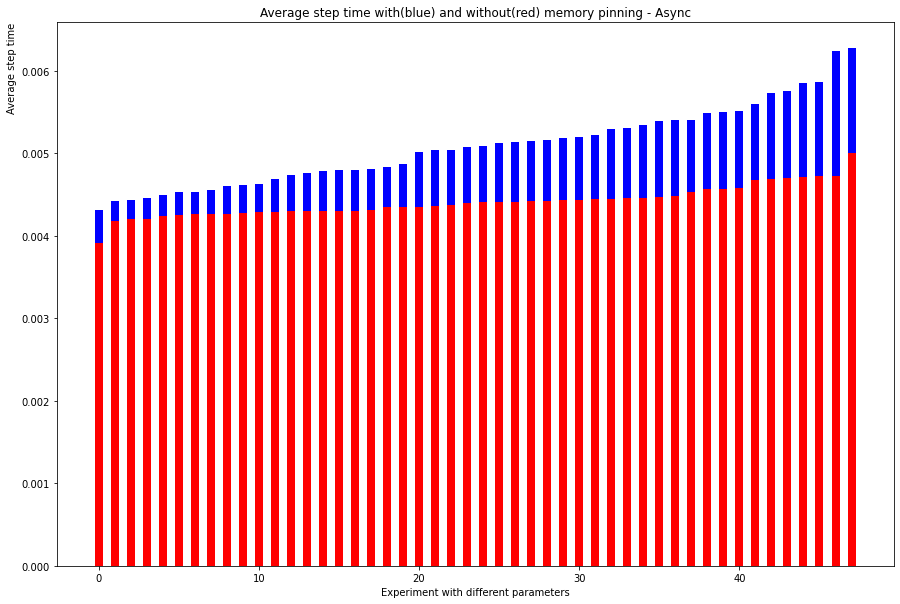

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')
del data

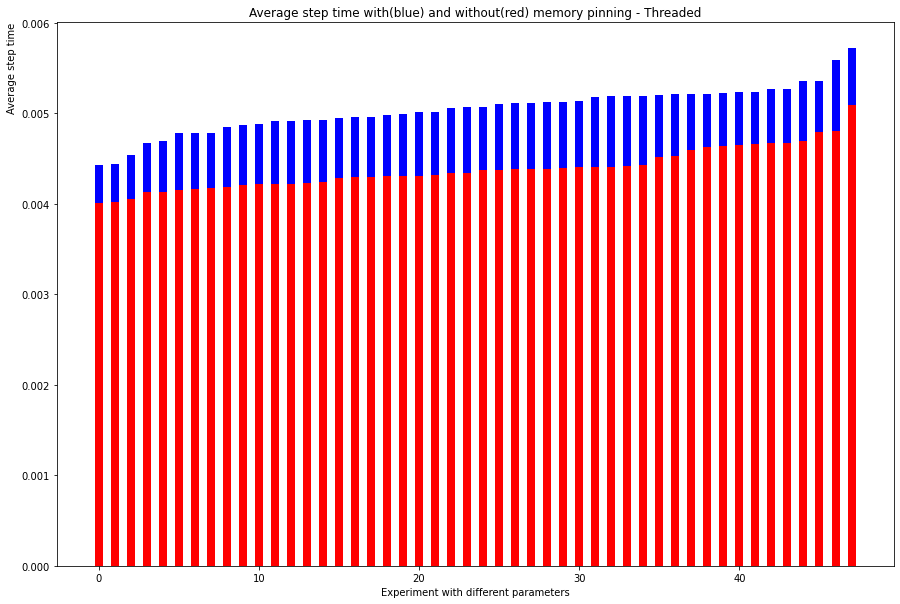

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Threaded", loc='center')
del data

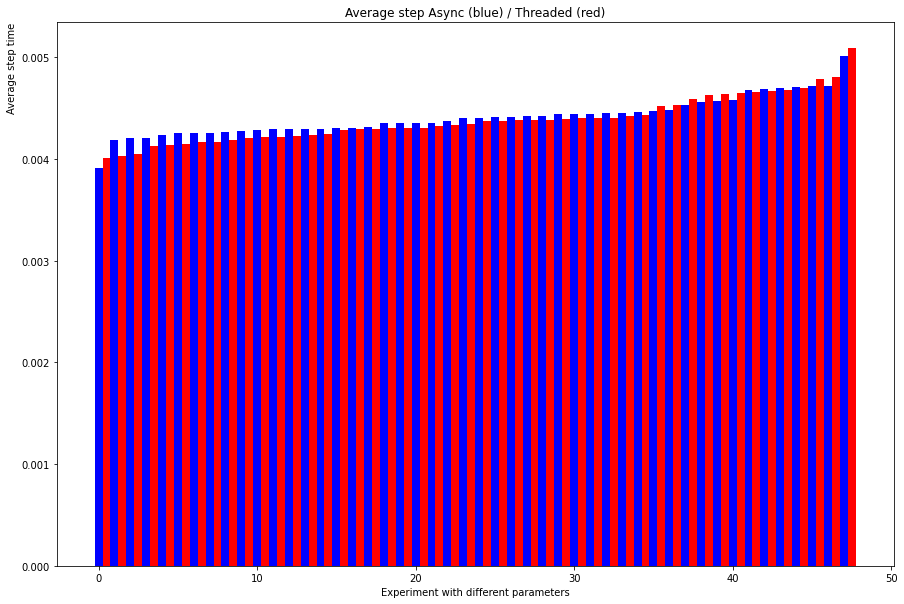

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.5 for x in range(len(data))], height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step Async (blue) / Threaded (red)", loc='center')
del data

Considering end to end implementation asyncio and threaded implementation seem to be comparable, though threaded seems to be slightly better in most cases. 

### Asyncio vs Threaded for S3 <a class="anchor" id="s3asynciovsthreaded">

In [17]:
from matplotlib.patches import Patch

num_workers_unique = np.unique(data_s3_async["num_workers"].to_numpy())
batch_size_unique = np.unique(data_s3_async["batch_size"].to_numpy())
num_fetch_workers_unique = np.unique(data_s3_async["num_fetch_workers"].to_numpy())


In [18]:
def plot_data(dataframe, fixed_param, fixed_value, changing_param, changing_values):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    colors = sns.color_palette(None, len(changing_values))
    param_colors = dict(zip(changing_values, colors))
    patches = [Patch(color=v, label=k) for k, v in param_colors.items()]
    
    for d, df in enumerate(dataframe):
        for pin_memory in [0, 1]:
            for i, param in enumerate(changing_values):
                plot_data = []
                for num_workers in num_workers_unique:
                    data = df[(df["num_workers"]==num_workers) & 
                                      (df["pin_memory"]==pin_memory) & 
                                      (df[changing_param]==param) & 
                                      (df[fixed_param]==fixed_value)].sort_values(["mean"], ascending=True)
                    plot_data.append(data["mean"].to_list()[0])
                ax[d].plot(num_workers_unique, plot_data, color=colors[i], linestyle="--" if pin_memory == 1 else "-")

        ax[d].legend(title=changing_param, 
                  handles=patches, 
                  loc='upper left', borderaxespad=0, fontsize=10, frameon=False)
        ax[d].set_xlabel("Number workers", loc="center")
        ax[d].set_ylabel("Average step time", loc="top")
        ax[d].set_title(f"Average step time vs {changing_param} vs num workers \n (pin_memory = True -> dashed)", loc='center')

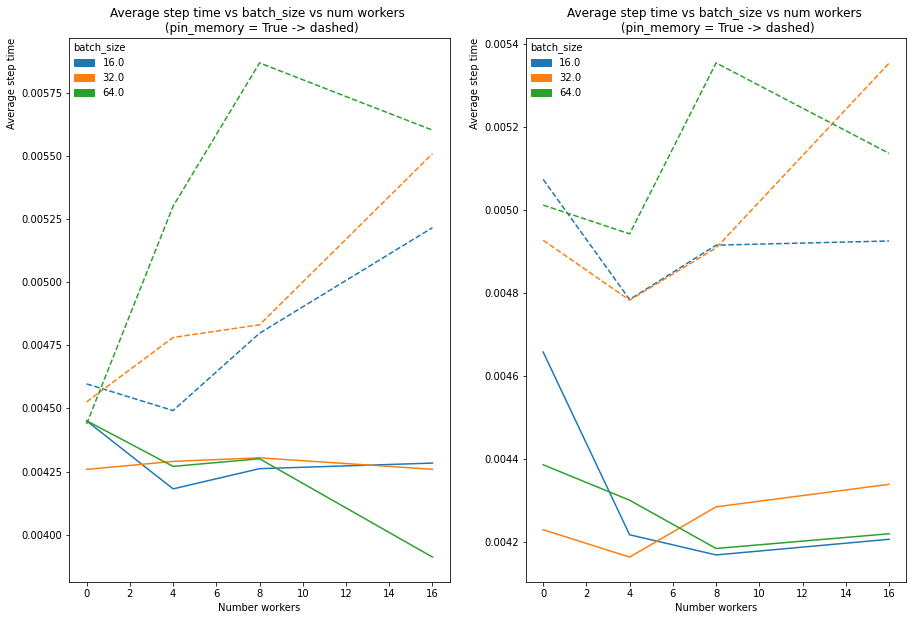

In [19]:
plot_data([data_s3_async, data_s3_threaded], "num_fetch_workers", 4, "batch_size", batch_size_unique)
# LEFT: Asyncio, RIGHT: Threaded

With smaller batches, and more workers, Asynio implementation provides the best average step time. What is interesting, from 0 to 8 workers it doesn't make a big difference, also for 16 and 32 workers. However, with 16 workers and batch size 64 it seems to be be the best.
In threaded implementation, number of workers matters more, and the sweet spot seems to be around 8, with larger batch size of 16 and 64. For batch size 32 the behavior seems to be a bit unexpected. 

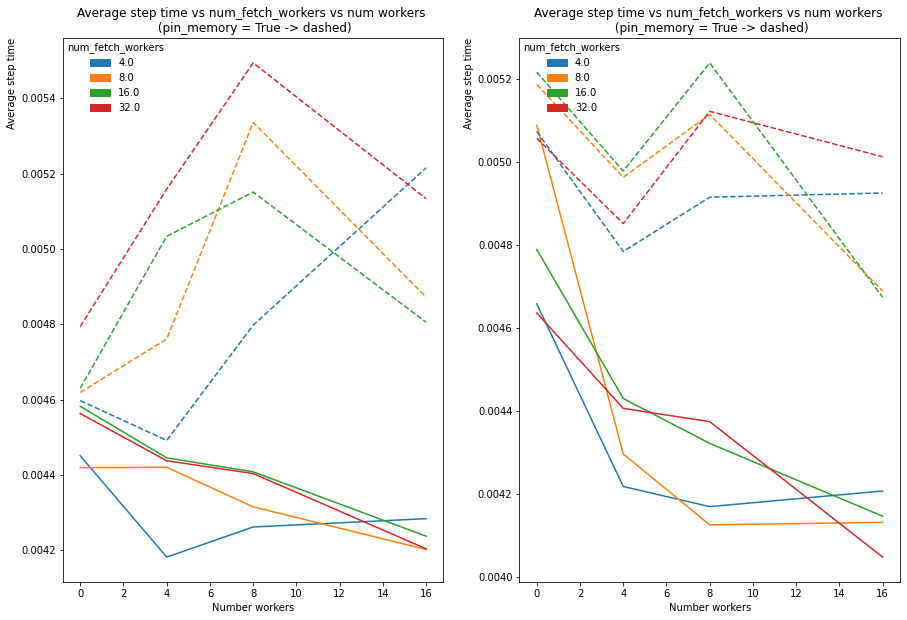

In [20]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

Increasing number of fetch workers, also works better when the number of workers is increased. 
Best performance seem to be when number of workers matches number of fetch workers. At least this is for asyncio, however with threaded implementation, again, number of workers initially matters a lot, and regardles of the fetch workers, average step time is better with more workers. Best choice seems to be 32 fetch workers with 16 workers. 

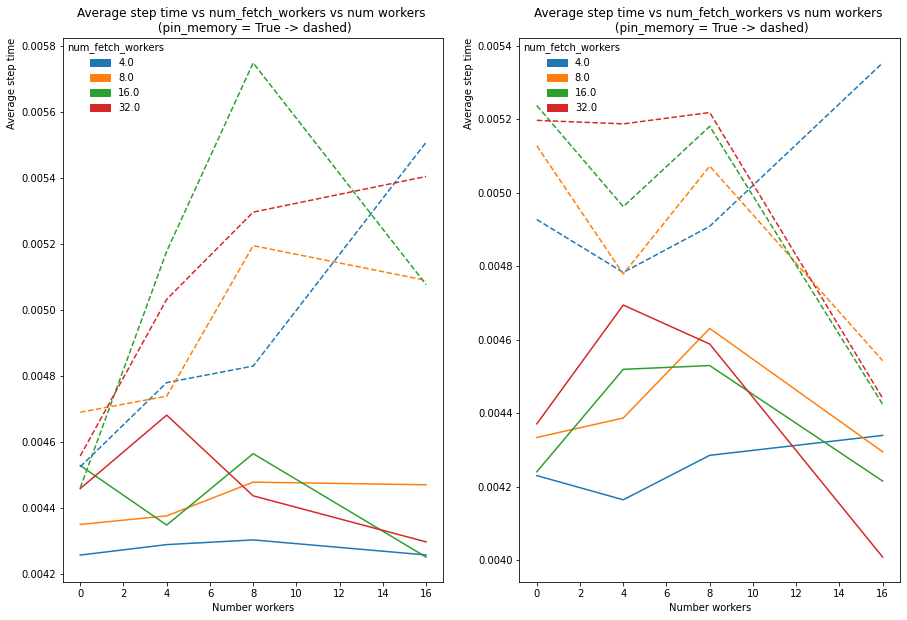

In [21]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

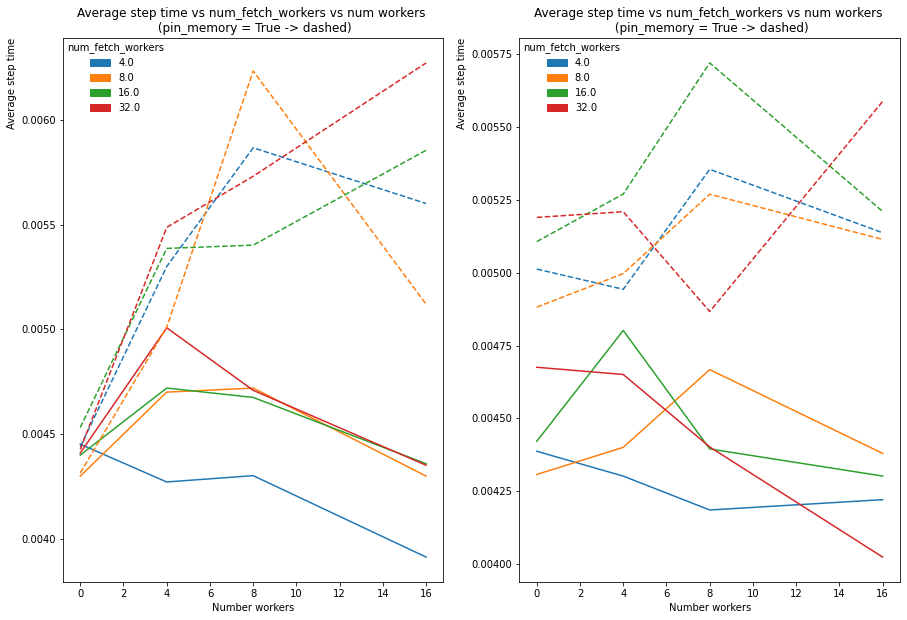

In [22]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

With increasing the batch size, it seems that with both implementation more workers with more fetch workers seems to work better. However, it seems that in some cases low number of fetch workers (e.g. blue) with a lot of workers isn't a good choice.

In [23]:
# For later comparison with Scratch
s3_pin_async = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_async = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
s3_pin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
# Cleanup
del data_s3_async
del data_s3_threaded

# Scratch storage <a class="anchor" id="scratchstorage">

In [24]:
df_dataloader_scratch_full = extract_pandas(output_base_folder, folder_filter="latest/e2e/*benchmark_e2e_scratch*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15240/15240 [05:38<00:00, 45.00it/s]


In [25]:
df_dataloader_scratch_async=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="asyncio"]
df_dataloader_scratch_threaded=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="threaded"]
# save memory 
del df_dataloader_scratch_full
# show record num
print(f"Records {len(df_dataloader_scratch_async)}")
print(f"Records {len(df_dataloader_scratch_threaded)}")

Records 1891780
Records 2169650


In [ ]:
display(get_run_stats(df_dataloader_scratch_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_scratch_threaded, group_by=group_by_dataloader))

In [26]:
print(np.unique(df_dataloader_scratch_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["batch_size"].to_numpy()))


[ 0  4  8 16]
[ 4  8 16 32]
[16 32 64]


In [27]:
data_scratch_async = filter_data(df_dataloader_scratch_async)
data_scratch_threaded = filter_data(df_dataloader_scratch_threaded)
# del df_dataloader_scratch_async
# del df_dataloader_scratch_threaded

In [28]:
data_scratch_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
90,0.003846,0.003487,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
48,0.003910,0.003726,0.0,8.0,4.0,16.0,"8, 4, 16, 0"
72,0.003928,0.003489,0.0,16.0,4.0,16.0,"16, 4, 16, 0"
84,0.004000,0.003732,0.0,16.0,16.0,16.0,"16, 16, 16, 0"
78,0.004017,0.003647,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
...,...,...,...,...,...,...,...
47,0.007288,0.004918,1.0,4.0,32.0,64.0,"4, 32, 64, 1"
71,0.007386,0.003949,1.0,8.0,32.0,64.0,"8, 32, 64, 1"
35,0.007511,0.004165,1.0,4.0,8.0,64.0,"4, 8, 64, 1"
29,0.007664,0.004250,1.0,4.0,4.0,64.0,"4, 4, 64, 1"


In [29]:
data_scratch_threaded.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
80,0.003463,0.002917,0.0,16.0,8.0,32.0,"16, 8, 32, 0"
88,0.003492,0.003109,0.0,16.0,16.0,64.0,"16, 16, 64, 0"
94,0.003543,0.003080,0.0,16.0,32.0,64.0,"16, 32, 64, 0"
74,0.003546,0.003136,0.0,16.0,4.0,32.0,"16, 4, 32, 0"
86,0.003653,0.003229,0.0,16.0,16.0,32.0,"16, 16, 32, 0"
...,...,...,...,...,...,...,...
71,0.005920,0.003889,1.0,8.0,32.0,64.0,"8, 32, 64, 1"
29,0.005933,0.004795,1.0,4.0,4.0,64.0,"4, 4, 64, 1"
41,0.006152,0.004635,1.0,4.0,16.0,64.0,"4, 16, 64, 1"
47,0.006253,0.004569,1.0,4.0,32.0,64.0,"4, 32, 64, 1"


concl...

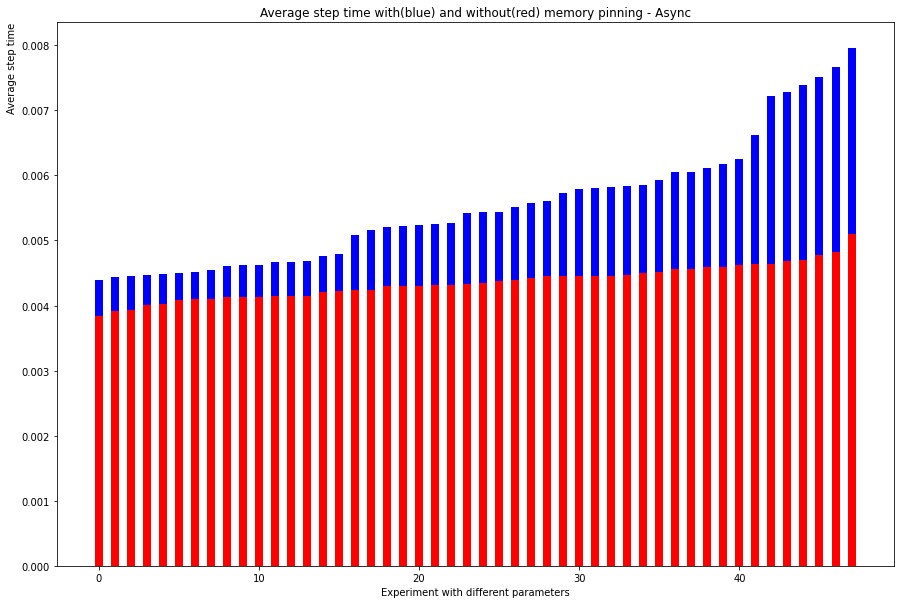

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))

data = data_scratch_async[data_scratch_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

      
ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')

del data


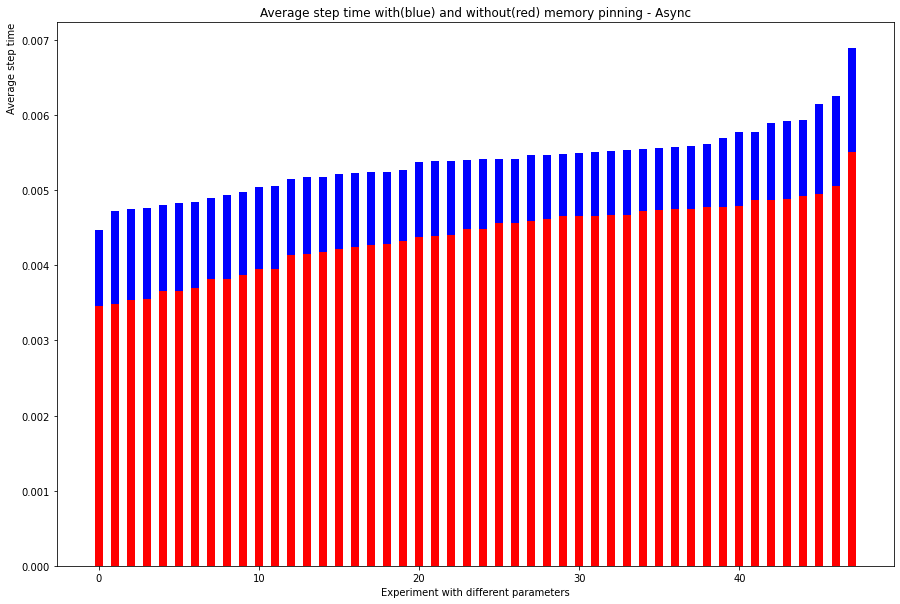

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')
del data

### Asyncio vs Threaded for Scratch <a class="anchor" id="scratchasynciovsthreaded">

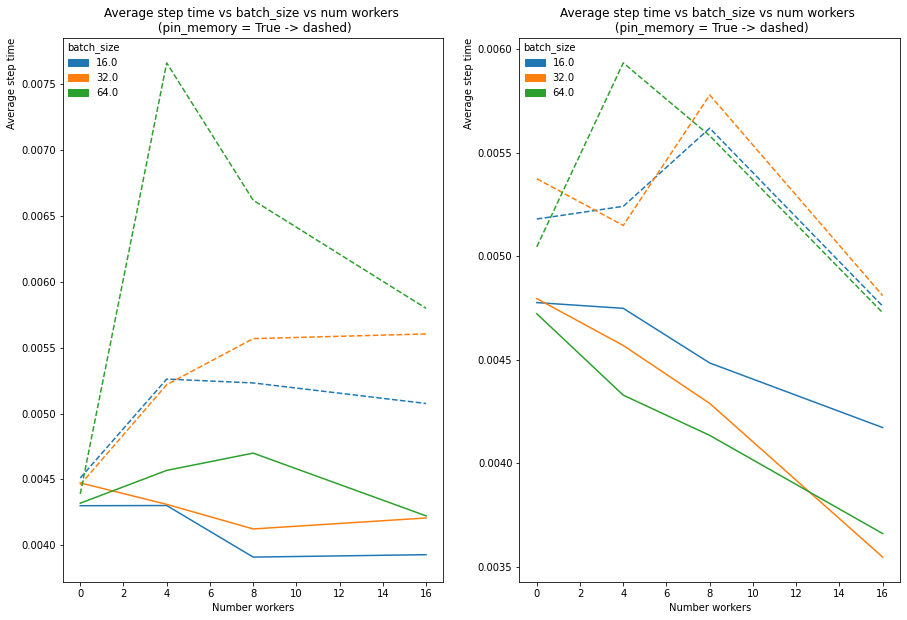

In [32]:
plot_data([data_scratch_async, data_scratch_threaded], "num_fetch_workers", 4, "batch_size", batch_size_unique)

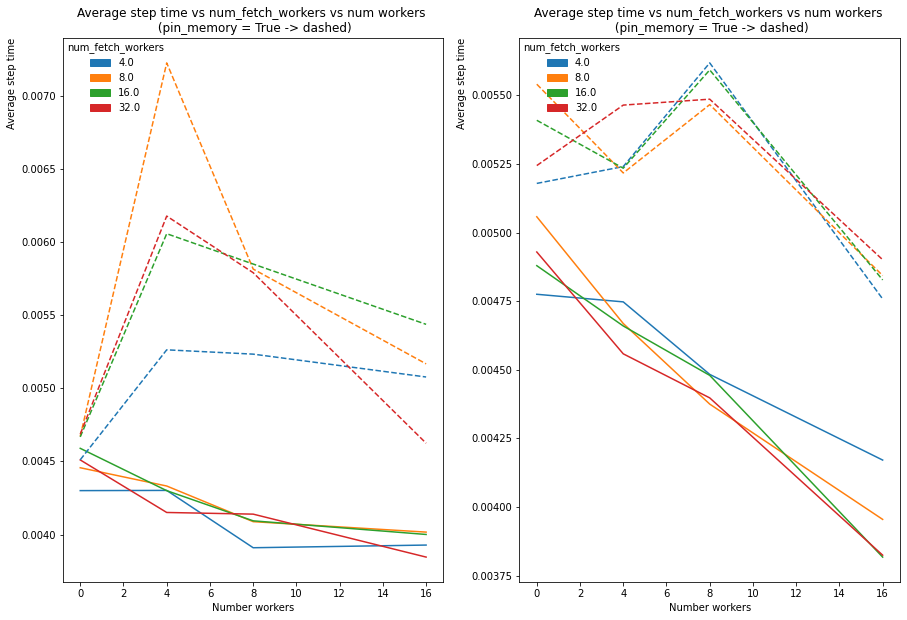

In [33]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

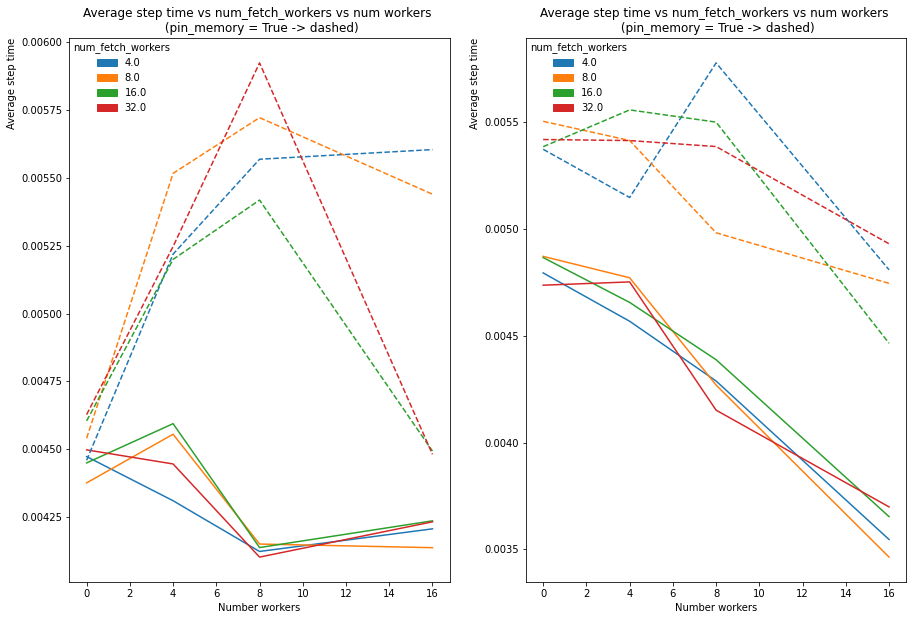

In [34]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

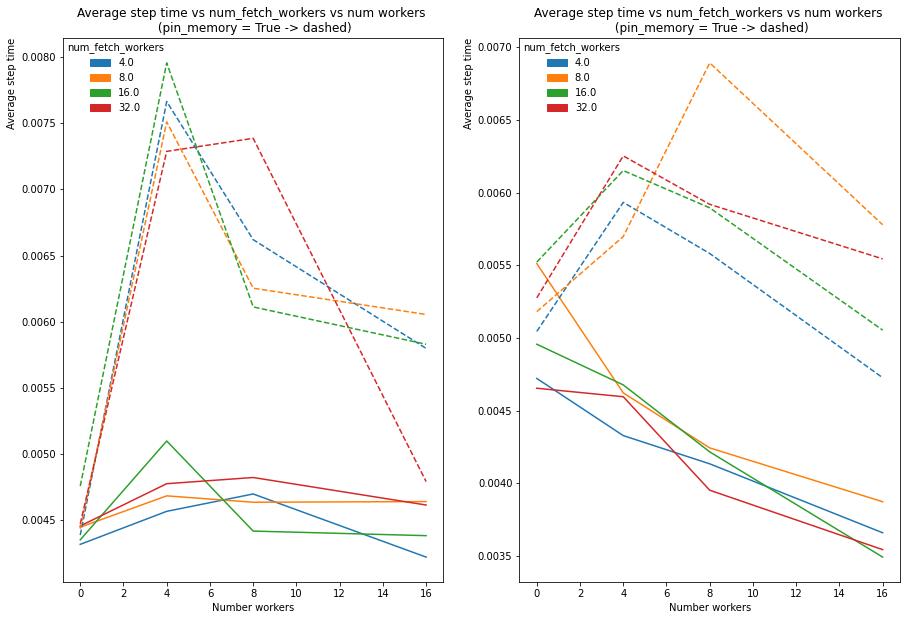

In [35]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

### S3 vs Scratch - mean step time  <a class="anchor" id="s3vsscratch">

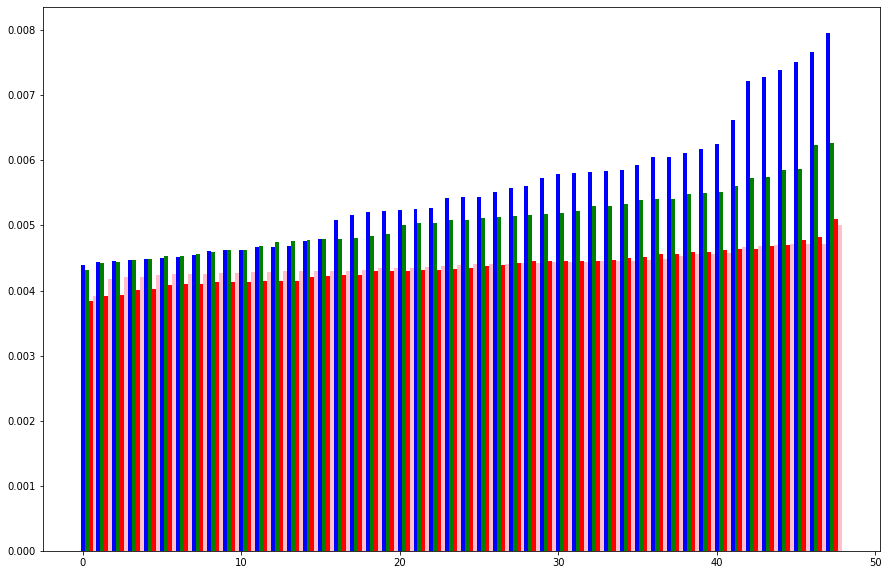

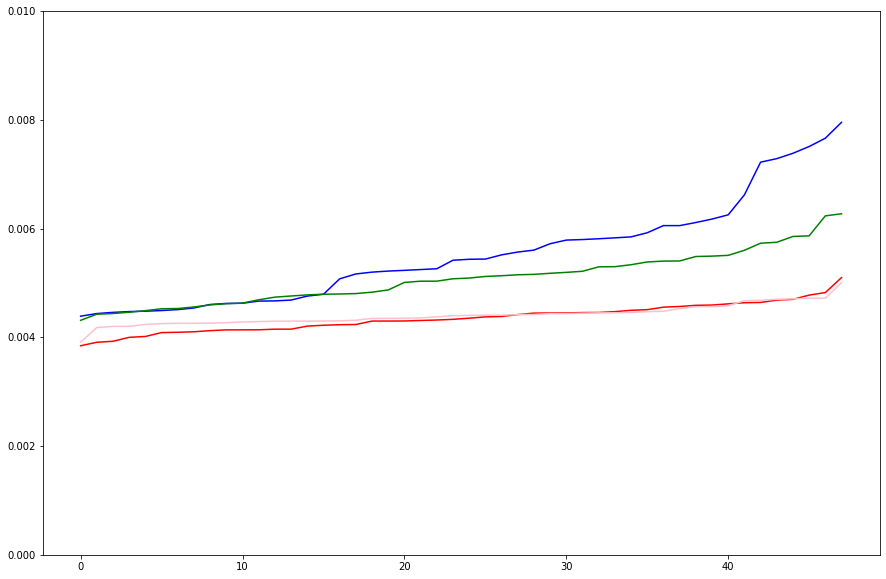

In [36]:
scratch_pin_async = data_scratch_async[data_scratch_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
scratch_unpin_async = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
scratch_pin_threaded = data_scratch_threaded[data_scratch_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
scratch_unpin_threaded = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)

# async
w = 1.0/4.0
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(scratch_pin_async)), height=scratch_pin_async["mean"], width=w, color="blue")
ax.bar(x=[x+0.25 for x in range(len(s3_pin_async))], height=s3_pin_async["mean"], width=w, color="green")
ax.bar(x=[x+0.5 for x in range(len(scratch_unpin_async))], height=scratch_unpin_async["mean"], width=w, color="red")
ax.bar(x=[x+0.75 for x in range(len(s3_unpin_async))], height=s3_unpin_async["mean"], width=w, color="pink")

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue")
ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"], color="green")
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="red")
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="pink")


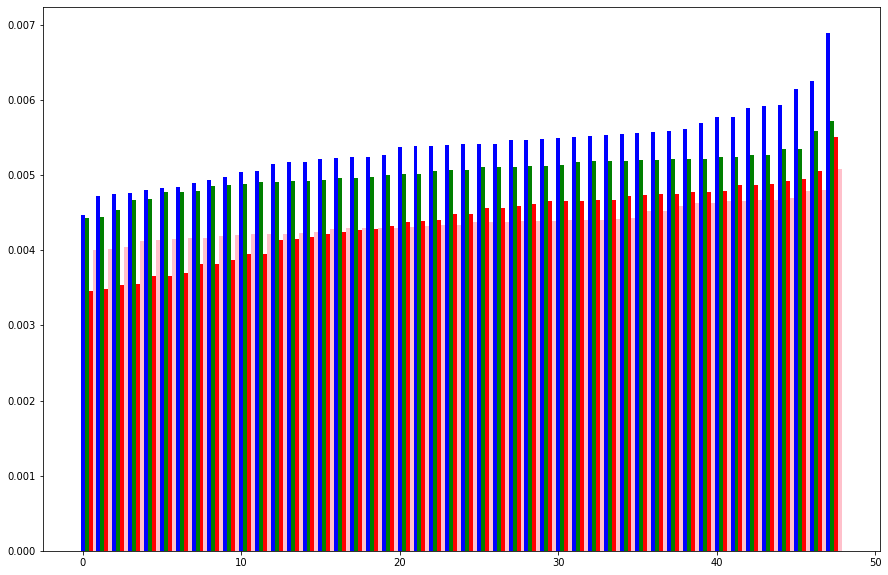

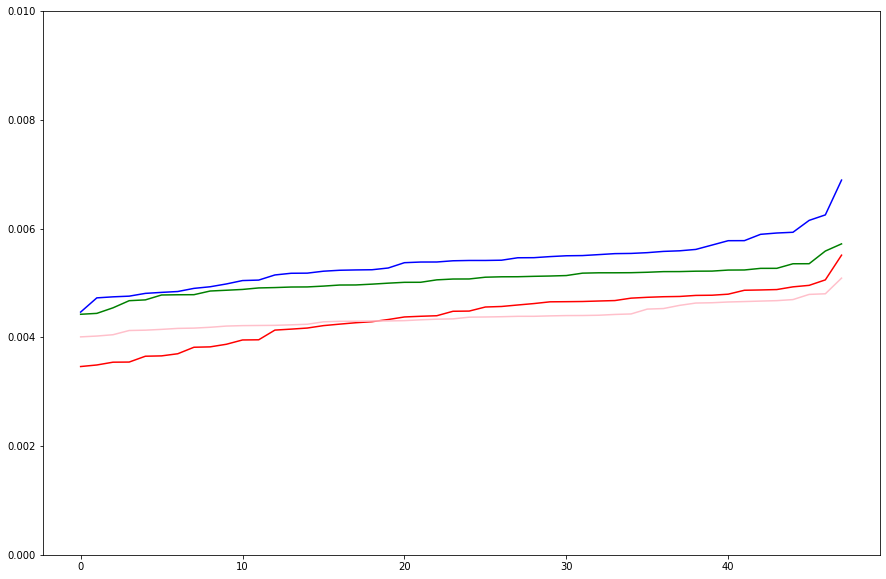

In [37]:
# threaded
w = 1.0/4.0
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(scratch_pin_threaded)), height=scratch_pin_threaded["mean"], width=w, color="blue")
ax.bar(x=[x+0.25 for x in range(len(s3_pin_threaded))], height=s3_pin_threaded["mean"], width=w, color="green")
ax.bar(x=[x+0.5 for x in range(len(scratch_unpin_threaded))], height=scratch_unpin_threaded["mean"], width=w, color="red")
ax.bar(x=[x+0.75 for x in range(len(s3_unpin_threaded))], height=s3_unpin_threaded["mean"], width=w, color="pink")

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="blue")
ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], color="green")
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="red")
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="pink")


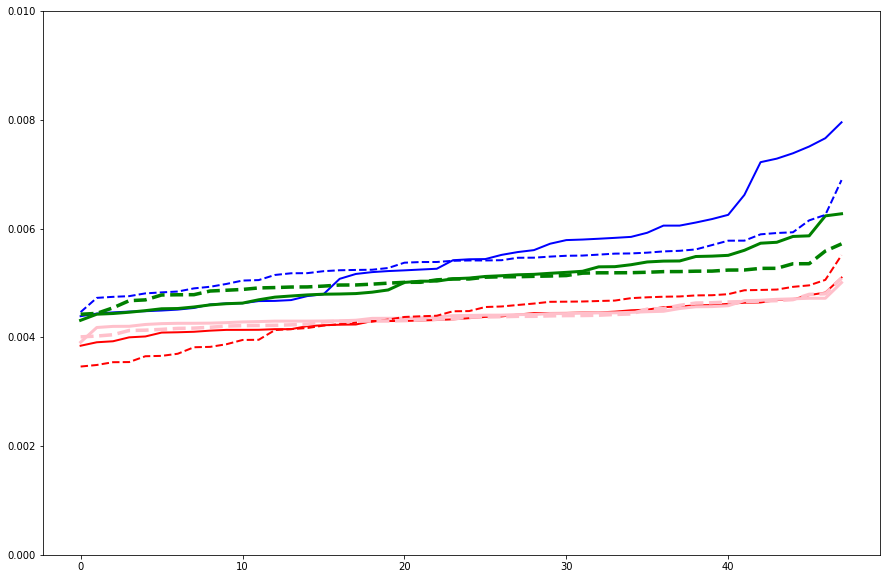

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue", linewidth=2)
ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"], color="green", linewidth=3)
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="red", linewidth=2)
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="pink", linewidth=3)
ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="blue", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], color="green", linestyle="--", linewidth=3.5)
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="red", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="pink", linestyle="--", linewidth=3.5)
# threaded is dashed, S3 is thicker

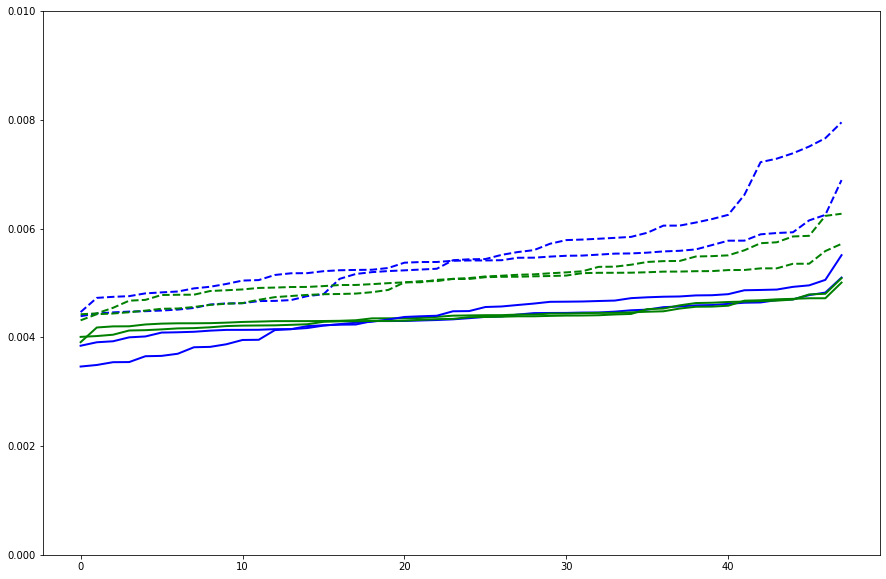

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"], color="green", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="blue", linewidth=2)
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="green", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="blue", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], color="green", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="blue", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="green", linewidth=2)
# Scratch is blue, S3 is green, pinned is dashed

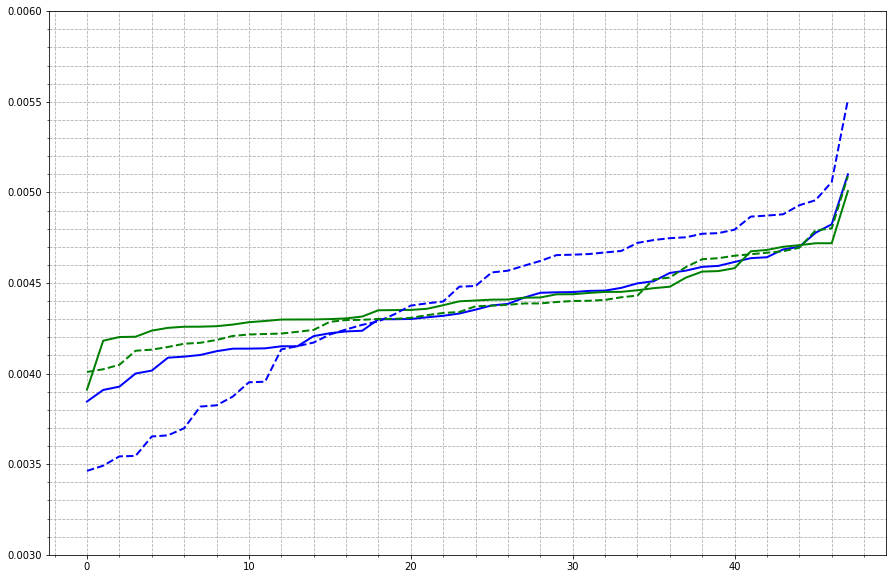

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.006)
ax.minorticks_on()
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="blue", linewidth=2)
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="green", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="blue", linestyle="--", linewidth=2)
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="green", linestyle="--", linewidth=2)
ax.grid(linestyle='--', which="both")
# S3 Green, Scratch blue, dashed threaded implementation
# Compare s3 to scratch -> e.g. scratch async and s3 async; full line, or dashed line for threaded impl.
# Green should be closer or bellow the blue

Considering the chart, we can ignore pinning memory, and just explore S3 vs Scratch for cases pin_memory=False:

We find that with some combinations we can get slightly better performance.

In [41]:
df_joined = pd.concat([s3_unpin_async[["mean", "config"]], 
                       s3_unpin_threaded[["mean", "config"]], 
                       scratch_unpin_async[["mean", "config"]], 
                       scratch_unpin_threaded[["mean", "config"]]], axis=1)
df_joined.reset_index(drop=True, inplace=True)

df_joined['diff_as'] = df_joined.apply(lambda row: float(row[4] - row[0]) , axis = 1)
df_joined['diff_thr'] = df_joined.apply(lambda row: float(row[6] - row[2]) , axis = 1)
df_joined = df_joined.set_axis(["s3_as_m", 
                                "s3_as_m_cfg", 
                                "s3_thr_m", 
                                "s3_thr_m_cfg",
                                "sc_as_m", 
                                "sc_as_m_cfg", 
                                "sc_thr_m", 
                                "sc_thr_m_cfg", 
                                "diff_as",
                                "diff_thr"], axis=1, inplace=False)


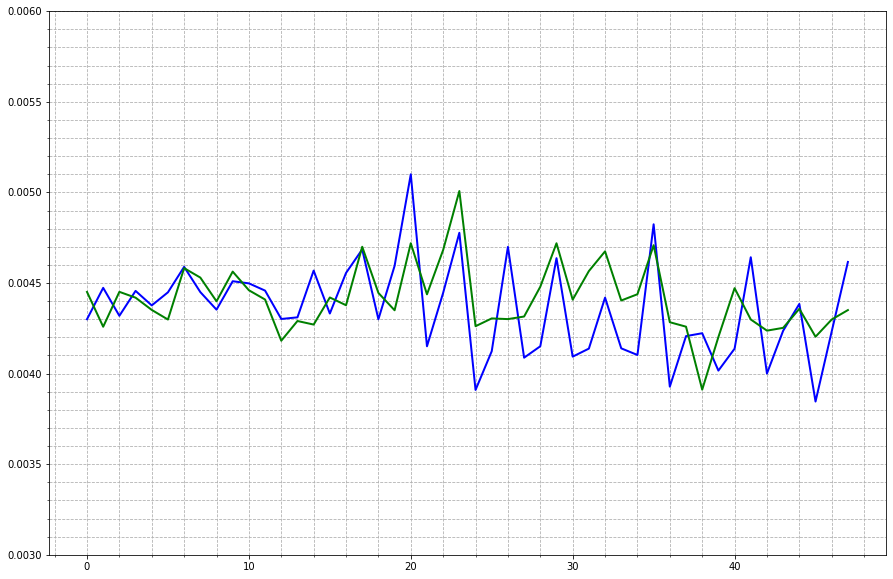

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.006)
ax.minorticks_on()
ax.plot(range(len(df_joined)), df_joined["sc_as_m"], color="blue", linewidth=2)
ax.plot(range(len(df_joined)), df_joined["s3_as_m"], color="green", linewidth=2)
ax.grid(linestyle='--', which="both")

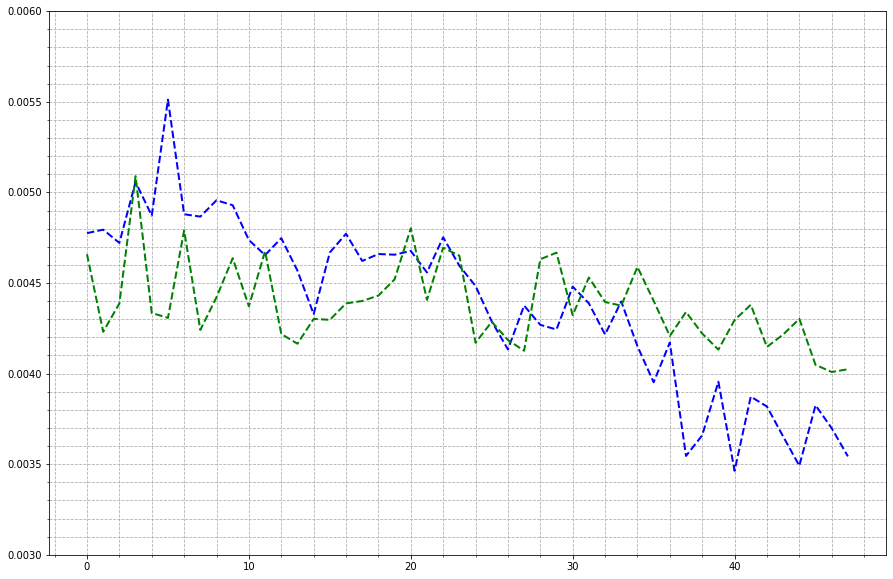

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.006)
ax.minorticks_on()
ax.plot(range(len(df_joined)), df_joined["sc_thr_m"], color="blue", linestyle="--", linewidth=2)
ax.plot(range(len(df_joined)), df_joined["s3_thr_m"], color="green", linestyle="--", linewidth=2)
ax.grid(linestyle='--', which="both")

**When is S3 better?**
Config order: `{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}`

In [44]:
print(df_joined.sort_values(["diff_as"], ascending=False)[["s3_as_m", "s3_as_m_cfg", "sc_as_m", "sc_as_m_cfg", "diff_as"]].head())

     s3_as_m   s3_as_m_cfg   sc_as_m   sc_as_m_cfg   diff_as
26  0.004301   8, 4, 64, 0  0.004700   8, 4, 64, 0  0.000399
20  0.004719  4, 16, 64, 0  0.005100  4, 16, 64, 0  0.000380
41  0.004299  16, 8, 64, 0  0.004642  16, 8, 64, 0  0.000343
38  0.003911  16, 4, 64, 0  0.004223  16, 4, 64, 0  0.000311
14  0.004271   4, 4, 64, 0  0.004568   4, 4, 64, 0  0.000298


In [45]:
print(df_joined.sort_values(["diff_thr"], ascending=False)[["s3_thr_m", "s3_thr_m_cfg", "sc_thr_m", "sc_thr_m_cfg", "diff_thr"]].head())

   s3_thr_m  s3_thr_m_cfg  sc_thr_m  sc_thr_m_cfg  diff_thr
5  0.004308   0, 8, 64, 0  0.005512   0, 8, 64, 0  0.001204
7  0.004241  0, 16, 32, 0  0.004866  0, 16, 32, 0  0.000625
1  0.004231   0, 4, 32, 0  0.004794   0, 4, 32, 0  0.000564
4  0.004334   0, 8, 32, 0  0.004872   0, 8, 32, 0  0.000537
8  0.004421  0, 16, 64, 0  0.004957  0, 16, 64, 0  0.000535


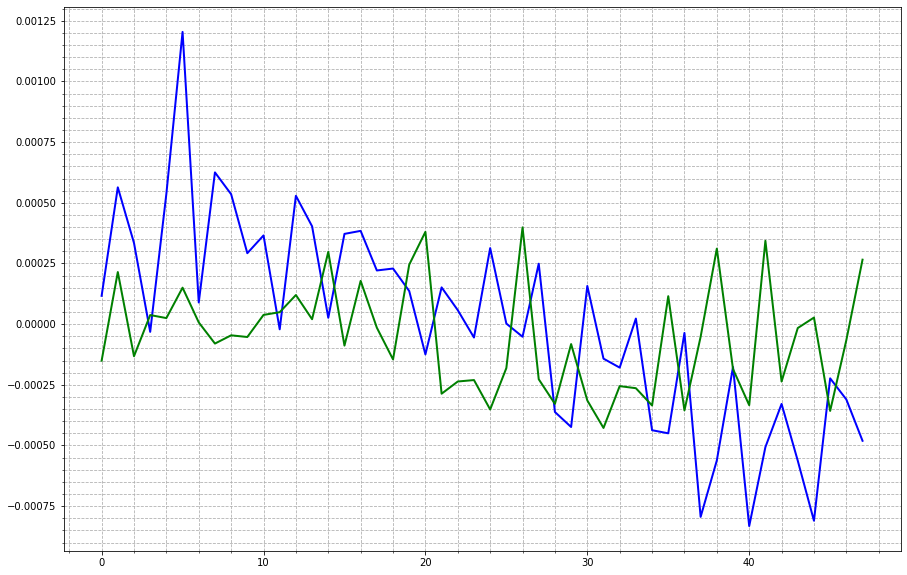

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.minorticks_on()
diff_thr = df_joined["diff_thr"]
diff_a = df_joined["diff_as"]
ax.plot(range(len(diff_thr)), diff_thr, color="blue", linewidth=2)
ax.plot(range(len(diff_a)), diff_a, color="green", linewidth=2)
ax.grid(linestyle='--', which="both")
# difference between S3 and Scratch, for threaded and async implementation
